In [1]:
import scipy as sp
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

from ggqpy import construct_Chebyshev_quadratures
from ggqpy.functionfamiliy import Interval
from ggqpy.testproblems import example_problem, gen_poly_and_sing
from ggqpy.discretize import Discretizer
from ggqpy.compress import compress_sequence_of_functions, visualise_diagonal_dropoff, construct_A_matrix
from ggqpy.optimize import QuadOptimizer
from ggqpy.visualize import plot_points

Baseline

In [2]:
L = 7
K = 2*(L + 1)**2
print("K =",K)
disc = Discretizer()
M = L+1
N = 2*L + 2
t_d,phi_d,w_d,_,_ = disc.naive_discretize2d_sphere(150, 150)
t_n,phi_n,w_n,_,_ = disc.naive_discretize2d_sphere(M, N)
theta_n = np.arccos(t_n)
theta_d = np.arccos(t_d)

K = 128


Lebedev

In [3]:
data = np.genfromtxt('lebedev011.txt')
phi_l, theta_l, w_l = np.hsplit(data, 3)
phi_l = phi_l.flatten()
theta_l = theta_l.flatten()
phi_l = (phi_l/180 + 1)*np.pi
theta_l = theta_l*np.pi/180
w_l = 4*np.pi*w_l.flatten()

In [4]:
data = np.genfromtxt('lebedev131.txt')
phi_l131, theta_l131, w_l131 = np.hsplit(data, 3)
phi_l131 = phi_l131.flatten()
theta_l131 = theta_l131.flatten()
phi_l131 = (phi_l131/180 + 1)*np.pi
theta_l131 = theta_l131*np.pi/180
w_l131 = 4*np.pi*w_l131.flatten()

In [5]:
max_degree = 2*L
Y = lambda m, l: lambda theta, phi: sp.special.sph_harm(m, l, phi, theta)
# functions = [
#     lambda t, phi, m=m, l=l: sp.special.sph_harm(m, l, phi, np.arccos(t))
#     for l in range(max_degree, max_degree + 1)
#     for m in range(-l, l + 1)
# ]

In [20]:
rng = np.random.default_rng()
def give_function():
    m1 = rng.integers(low = 0, high = max_degree//2+1)
    m2 = rng.integers(low = 0, high = max_degree//2+1)
    def f(t, phi):
        theta = np.arccos(t)
        x = np.cos(phi)*np.sin(theta)
        y = np.sin(phi)*np.sin(theta)
        z = np.cos(theta)
        sigma2 = x**2*y**2 + x**2*z**2 + y**2*z**2
        sigma3 = (x*y*z)**2
        return sigma2**m1 + sigma3**m2
    return f
    
number_of_functions = 100
functions = [
    give_function() for _ in range(number_of_functions)
]

functions[0](0,1)

1.0

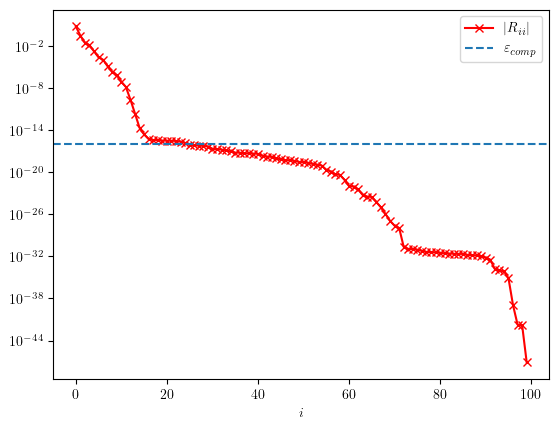

In [7]:
precision = 1e-16
U, rank = compress_sequence_of_functions(functions, (t_d, phi_d), w_d, precision)
(t_c, phi_c), w_c = construct_Chebyshev_quadratures((t_d, phi_d), w_d, U)
theta_c = np.arccos(t_c)
A = construct_A_matrix((t_d,phi_d),w_d,functions)
visualise_diagonal_dropoff(A,precision)

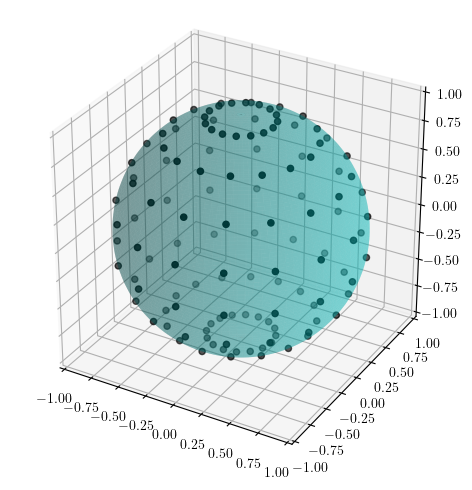

In [8]:
plot_points(theta_n,phi_n)

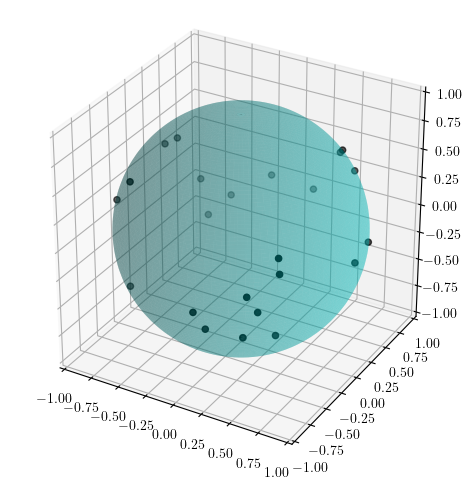

In [9]:
plot_points(np.arccos(t_c),phi_c)

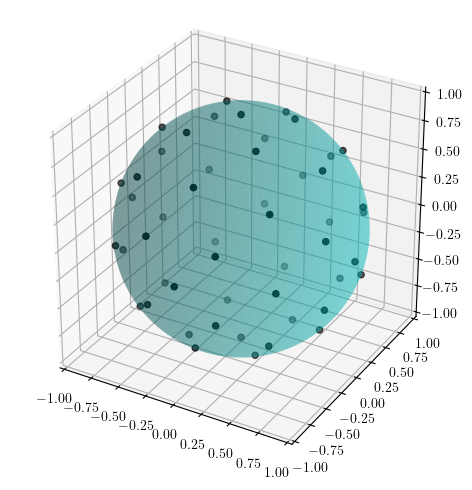

In [10]:
plot_points(theta_l,phi_l)

In [11]:
(m,l) = (8,5)
print("naive", len(theta_n))
for l in range(m + 6*L, m+ 6*L + 10):
    print(abs(Y(m,l)(np.cos(theta_n),phi_n)@w_n))

naive 128
7.993841331151423e-16
6.278411828284321e-16
6.565042403459464e-16
8.08382606107727e-16
9.933533925796951e-16
1.156885123464664e-15
1.2805690288858274e-15
1.3556193960895927e-15
1.3662645657550044e-15
1.2984501548691812e-15


In [12]:
print(abs((Y(21,100)(theta_n,phi_n)*Y(20,30)(np.cos(theta_n),phi_n))@w_n))

9.136367994371133e-18


In [13]:
err_c = list()
err_l = list()
err_n = list()
rng = np.random.default_rng()
for l in range(4*L+10):
    m = rng.integers(low = -l, high = l+1)
    m = l
    
    test = lambda theta, phi, w: Y(m,l)(theta_l131,phi_l131)@w_l131
    Iref = Y(m,l)(theta_l131,phi_l131)@w_l131
    err_c.append(abs((Y(m,l)(np.arccos(t_c),phi_c))@w_c - Iref))
    err_n.append(abs((Y(m,l)(np.arccos(t_n),phi_n))@w_n - Iref))
    err_l.append(abs((Y(m,l)(theta_l,phi_l))@w_l - Iref))

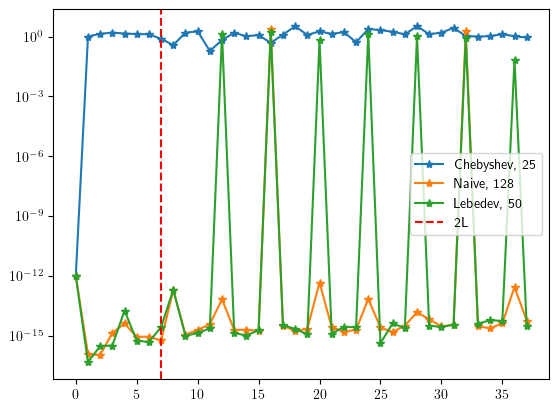

In [14]:
plt.semilogy(err_c, "-*", label=r"Chebyshev, " + str(len(t_c)))
plt.semilogy(err_n, "-*", label=r"Naive, " + str(len(t_n)))
plt.semilogy(err_l, "-*", label=r"Lebedev, " + str(len(theta_l)))
plt.axvline(L, linestyle="--", color="r", label="2L")
plt.legend()

In [15]:
err_c = list()
err_l = list()
err_n = list()
rng = np.random.default_rng()
for l in range(70):
    m = rng.integers(low = -l, high = l+1)
    l1 = l
    l2 = l
    m1 = l
    m2 = l
    
    test = lambda theta, phi, w: (Y(m1,l1)(theta,phi)*Y(m2,l2)(theta,phi).conj())@w
    Iref = test(theta_l131, phi_l131, w_l131)
    err_c.append(abs(test(theta_c, phi_c, w_c) - Iref))
    err_n.append(abs(test(theta_n, phi_n, w_n) - Iref))
    err_l.append(abs(test(theta_l, phi_l, w_l) - Iref))

In [16]:
(Y(4*L,4*L)(theta_c,phi_c)*Y(4*L,4*L)(theta_c,phi_c).conj())@w_c

(2.193438059283899+0j)

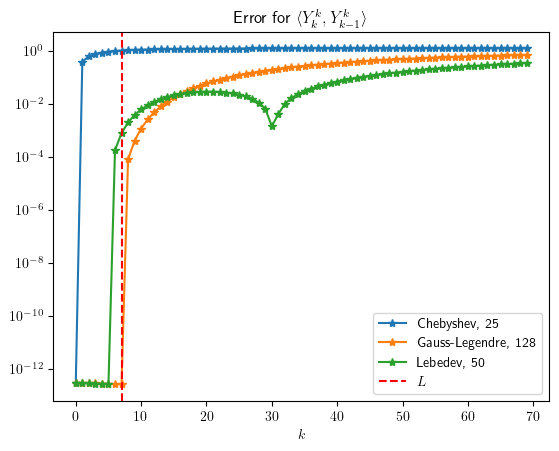

In [17]:
plt.semilogy(err_c, "-*", label=r"Chebyshev, " + str(len(t_c)))
plt.semilogy(err_n, "-*", label=r"Gauss-Legendre, " + str(len(t_n)))
plt.semilogy(err_l, "-*", label=r"Lebedev, " + str(len(theta_l)))
plt.title(r"Error for $\langle Y_{k}^k,Y_{k-1}^k \rangle$")
plt.xlabel(r"$k$")
plt.axvline(L, linestyle="--", color="r", label=r"$L$")
plt.legend();


In [18]:
print(len(functions))

100


In [19]:
l = 60
(Y(l,l)(theta_l,phi_l)*Y(l,l)(theta_l,phi_l).conj())@w_l

(1.2502237566758956+0j)